In [1]:
#Bibliotheken einbinden
import pandas as pd
from pathlib import Path
from numpy.polynomial.polynomial import polyfit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sensoren_skizze = [
    "TL", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9",
    "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"
]

# Entsprechende Excel-Spalten
sensoren_excel = [
    "T11", "T6", "T9", "T4", "T15", "T14", "T10", "T17", "T12", "T13",
    "T3", "T19", "T7", "T8", "T18", "T20", "T16", "T1", "T2", "T5"
]

# Mapping-Dictionary
skizze_to_excel = dict(zip(sensoren_skizze, sensoren_excel))
excel_to_skizze = dict(zip(sensoren_excel, sensoren_skizze))

sensor_hoehen = np.array([ # Nummerierung wie in Skizze
    0.0, #TL (Referenzpunkt)
    1.0, 0.5, 0.0, 0.0, 0.5, 1.0, #T1 - T6
    1.41, 1.51, 1.61, #T7 - T9
    1.0, 0.5, 0.0, 0.0, 0.5, 1.0, #T10 - T15
    1.25, 1.35, #T16 - T17
    1.25, 1.35 #T18 - T19
])

In [3]:
#Liefert Sensordaten in Skizzenreihenfolge
def hole_sensorwerte(df, sensoren_skizze):
    excel_spalten = [skizze_to_excel[s] for s in sensoren_skizze]
    return df[excel_spalten].values


In [4]:
datein = Path.cwd().glob("*.csv") #Dateipfad für csv-Dateien im selben Ordner wie Skript

cols = ["number", "date", "time"] + [f"T{i}" for i in range(1, 21)] #Kopfzeile erstellen, ersetzt die der csv-Datein

dfs = []

for i in datein:
    try:
        df = pd.read_csv(
            i,
            sep=";",
            encoding="latin1",
            skiprows=2,
            names=cols,
            usecols=range(23),
            on_bad_lines="skip"   # skippen von fehlerbehafteten Zellen
        )
        dfs.append(df)
    except pd.errors.EmptyDataError:
        continue

gesamt_df = pd.concat(dfs, ignore_index=True)

#COdeblock nötig zum bereinigen der dezimaltrenner. Beim Einlesen der CSV-Datein hat 'decimal=","' nicht zuverlässig funktioniert.
#Daher werden hier alle , durch . ersetzt und der String als Zahl abgespeichert

temp_spalten = gesamt_df.filter(like="T").columns #erstellen von einer Liste der Temperaturspalten


gesamt_df[temp_spalten] = ( #Ersetzen
    gesamt_df[temp_spalten]
    .astype(str)
    .replace(",", ".", regex = True)
    .apply(pd.to_numeric, errors="coerce")
)

#Codeblock zum erstellen eines Indexes für alle Zeilen aus spalten "Date" und "Time"

gesamt_df["datetime"] = pd.to_datetime(
    gesamt_df["date"] + " " + gesamt_df["time"],
    format="%d.%m.%Y %H:%M:%S"
)


gesamt_df = gesamt_df.set_index("datetime") #"datetime" als index setzen
gesamt_df = gesamt_df.sort_index() #Dataframe nach "datetime" sortieren

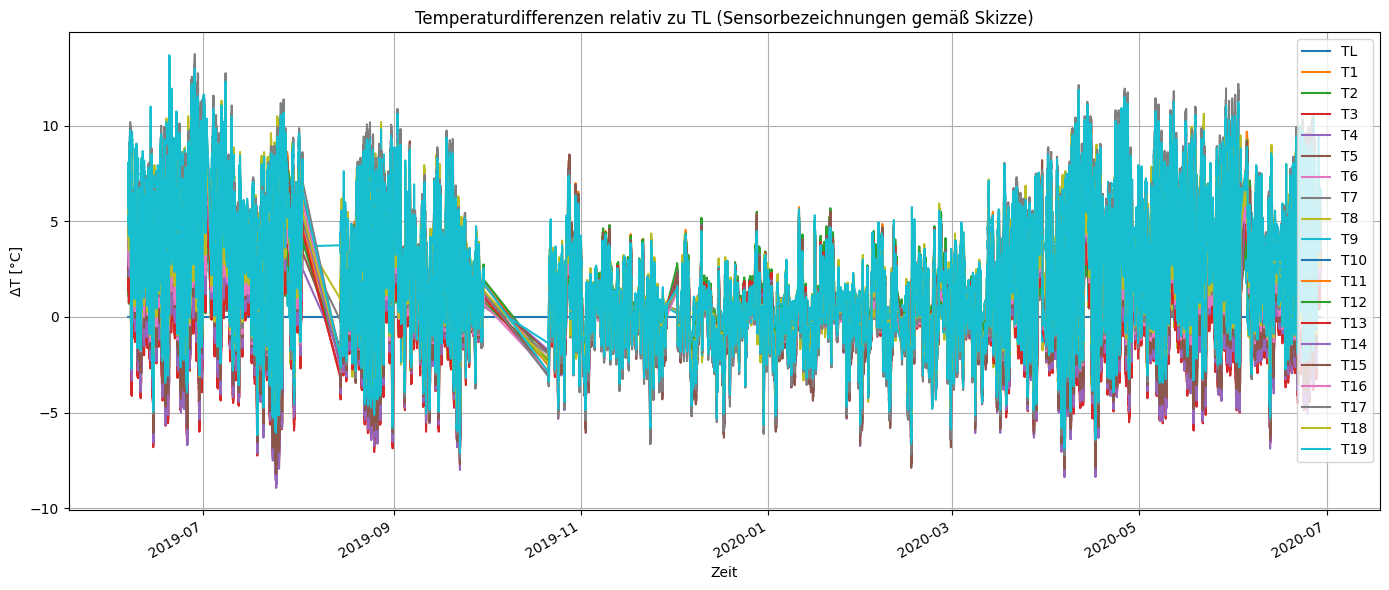

In [5]:
# Plot der Temperaturdifferenzen zu TL

# Sensordaten in Skizzenreihenfolge holen
werte_skizze = hole_sensorwerte(gesamt_df, sensoren_skizze)

# DataFrame mit Skizzenbezeichnungen erzeugen
df_skizze = pd.DataFrame(
    werte_skizze,
    index=gesamt_df.index,
    columns=sensoren_skizze
)

# Temperaturdifferenzen relativ zu TL
df_diff = df_skizze.sub(df_skizze["TL"], axis=0)

# Plot
df_diff.loc["2019-06-06":"2020-06-28"].plot(
    figsize=(14, 6),
    title="Temperaturdifferenzen relativ zu TL (Sensorbezeichnungen gemäß Skizze)",
)

plt.ylabel("ΔT [°C]")
plt.xlabel("Zeit")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
gradienten = []

werte = hole_sensorwerte(gesamt_df, sensoren_skizze)

for temps in werte:
    if np.isnan(temps).any():
        gradienten.append(np.nan)
        continue

    # TL ist erstes Element -> Referenz
    temps_rel = temps - temps[0]

    _, a = polyfit(sensor_hoehen, temps_rel, 1)
    gradienten.append(a)

gesamt_df["temp_gradient"] = gradienten


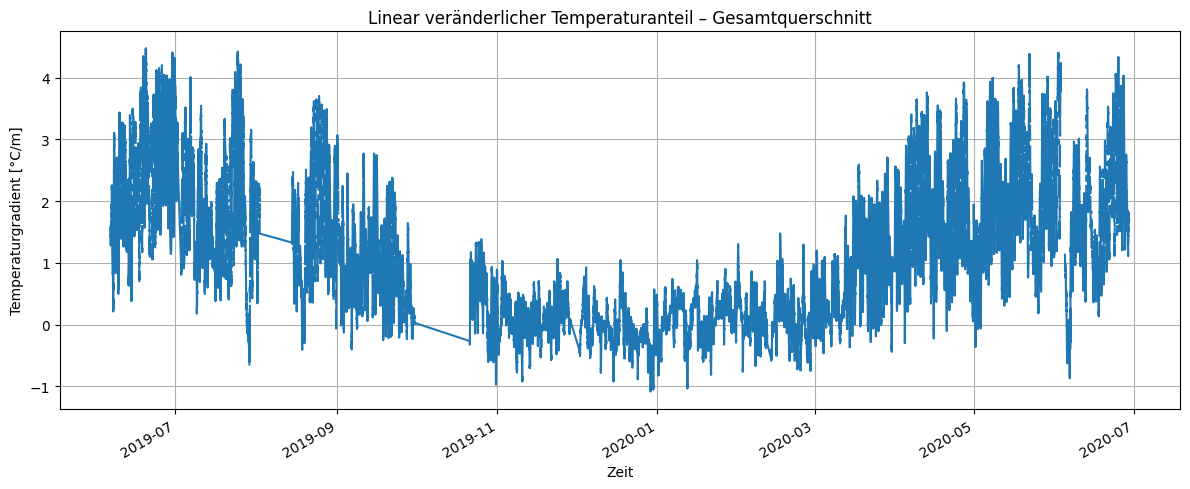

In [7]:
plt.figure(figsize=(12, 5))
gesamt_df["temp_gradient"].plot()
plt.ylabel("Temperaturgradient [°C/m]")
plt.xlabel("Zeit")
plt.title("Linear veränderlicher Temperaturanteil – Gesamtquerschnitt")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Schwerpunkt Aufgabe 1 – Teilquerschnitte

# T7, T8, T9 liegen in der QS-Mitte (hier nicht relevant)
# TL ist Referenzsensor (z = 0)

sensoren_links_skizze = ["TL", "T1", "T2", "T3", "T4", "T5", "T6", "T18", "T19"]
sensoren_rechts_skizze = ["TL", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17"]

hoehen_links = np.array([0.0, 1.0, 0.5, 0.0, 0.0, 0.5, 1.0, 1.25, 1.35])
hoehen_rechts = hoehen_links.copy()

# Hilfsfunktion: linearer Temperaturgradient

def berechne_gradient_skizze(df, sensoren_skizze_subset):
    idx = [sensoren_skizze.index(s) for s in sensoren_skizze_subset]
    hoehen = sensor_hoehen[idx]

    gradients = []
    werte = hole_sensorwerte(df, sensoren_skizze_subset)

    for temps in werte:
        if np.isnan(temps).any():
            gradients.append(np.nan)
            continue

        temps_rel = temps - temps[0]
        _, a = polyfit(hoehen, temps_rel, 1)
        gradients.append(a)

    return gradients


# Gradienten berechnen
gesamt_df["grad_linker_steg"] = berechne_gradient_skizze(
    gesamt_df, sensoren_links_skizze
)

gesamt_df["grad_rechter_steg"] = berechne_gradient_skizze(
    gesamt_df, sensoren_rechts_skizze
)

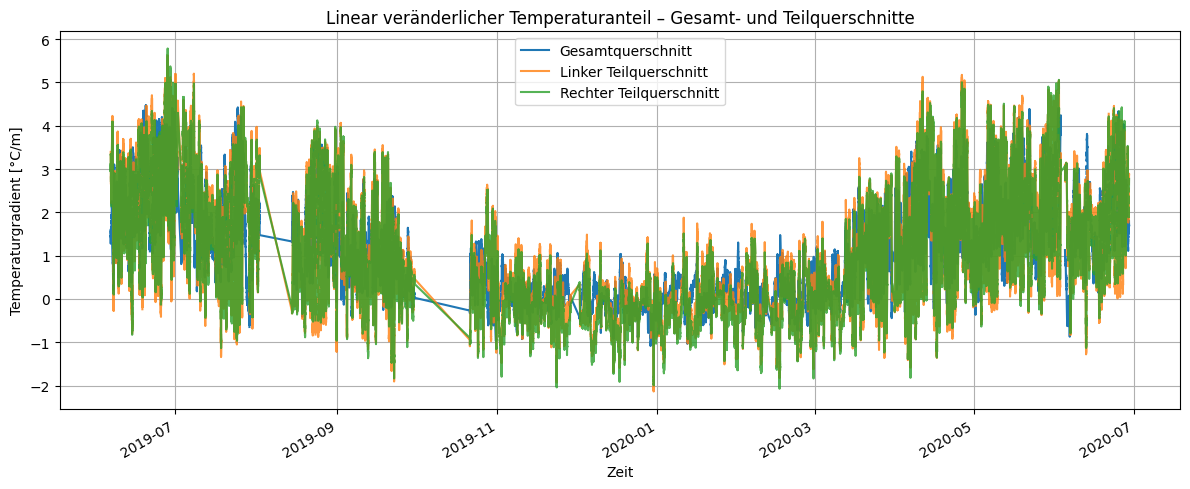

In [9]:
# Visualisierung: Vergleich
plt.figure(figsize=(12, 5))

gesamt_df["temp_gradient"].plot(
    label="Gesamtquerschnitt", linewidth=1.5
)
gesamt_df["grad_linker_steg"].plot(
    label="Linker Teilquerschnitt", alpha=0.8
)
gesamt_df["grad_rechter_steg"].plot(
    label="Rechter Teilquerschnitt", alpha=0.8
)

plt.ylabel("Temperaturgradient [°C/m]")
plt.xlabel("Zeit")
plt.title("Linear veränderlicher Temperaturanteil – Gesamt- und Teilquerschnitte")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Lukas Laptop\AppData\Local\Temp\ipykernel_10084\2422477632.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Bauwerksmonitoring\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


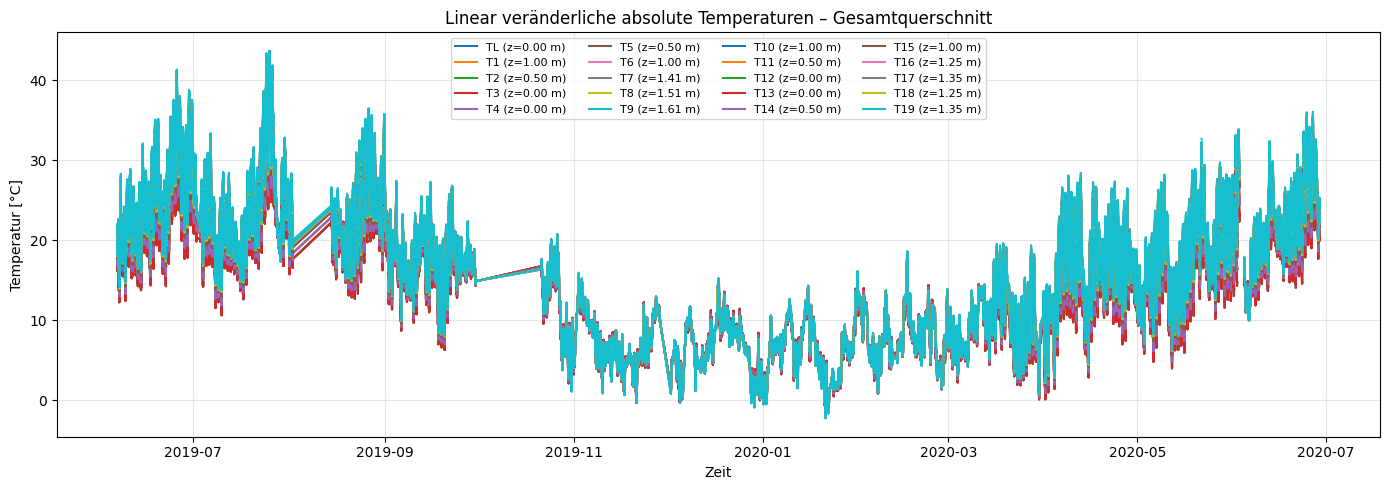

In [36]:
#Wiederholung: Gesamtquerschnitt und Teilquerschnitte mit abs. Temp.
# =====================================================
# Linear veränderliche absolute Temperaturen – Gesamtquerschnitt
# =====================================================

plt.figure(figsize=(14, 5))

TL = gesamt_df["T11"]          # TL = Referenzsensor (absolut)
a  = gesamt_df["temp_gradient"]

for z, sensor in zip(sensor_hoehen, sensoren_skizze):
    T_lin = TL + a * z
    plt.plot(gesamt_df.index, T_lin, label=f"{sensor} (z={z:.2f} m)")

plt.xlabel("Zeit")
plt.ylabel("Temperatur [°C]")
plt.title("Linear veränderliche absolute Temperaturen – Gesamtquerschnitt")
plt.legend(ncol=4, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\Lukas Laptop\AppData\Local\Temp\ipykernel_10084\3333288531.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


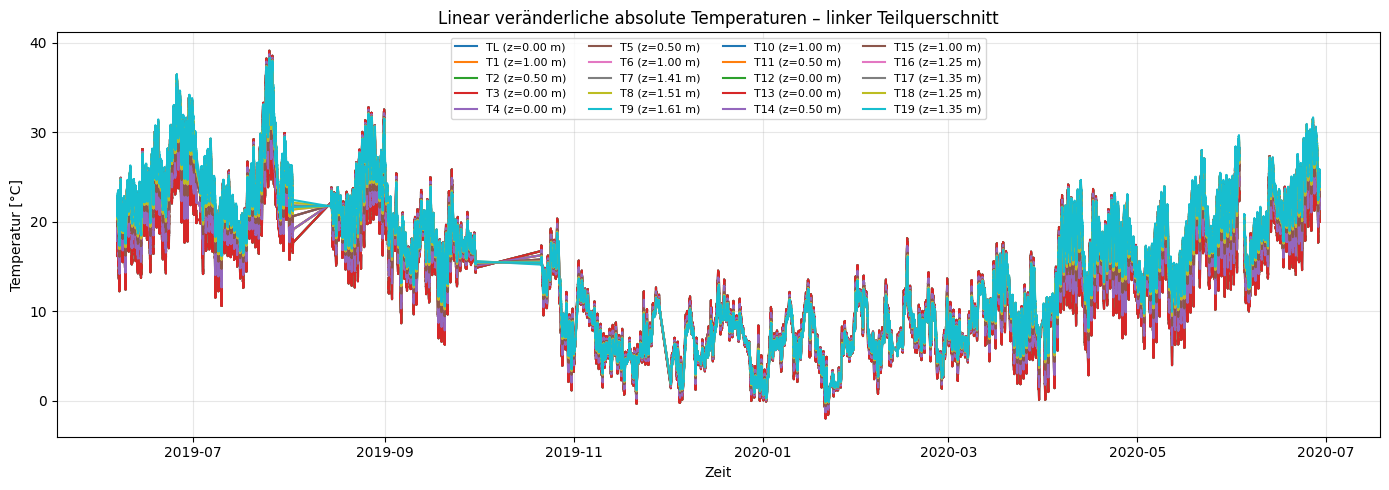

In [37]:
# =====================================================
# Linear veränderliche absolute Temperaturen – linker Teilquerschnitt
# =====================================================

plt.figure(figsize=(14, 5))

a_links = gesamt_df["grad_linker_steg"]

for z, sensor in zip(sensor_hoehen, sensoren_skizze):
    T_lin = TL + a_links * z
    plt.plot(gesamt_df.index, T_lin, label=f"{sensor} (z={z:.2f} m)")

plt.xlabel("Zeit")
plt.ylabel("Temperatur [°C]")
plt.title("Linear veränderliche absolute Temperaturen – linker Teilquerschnitt")
plt.legend(ncol=4, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\Lukas Laptop\AppData\Local\Temp\ipykernel_10084\3646941883.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


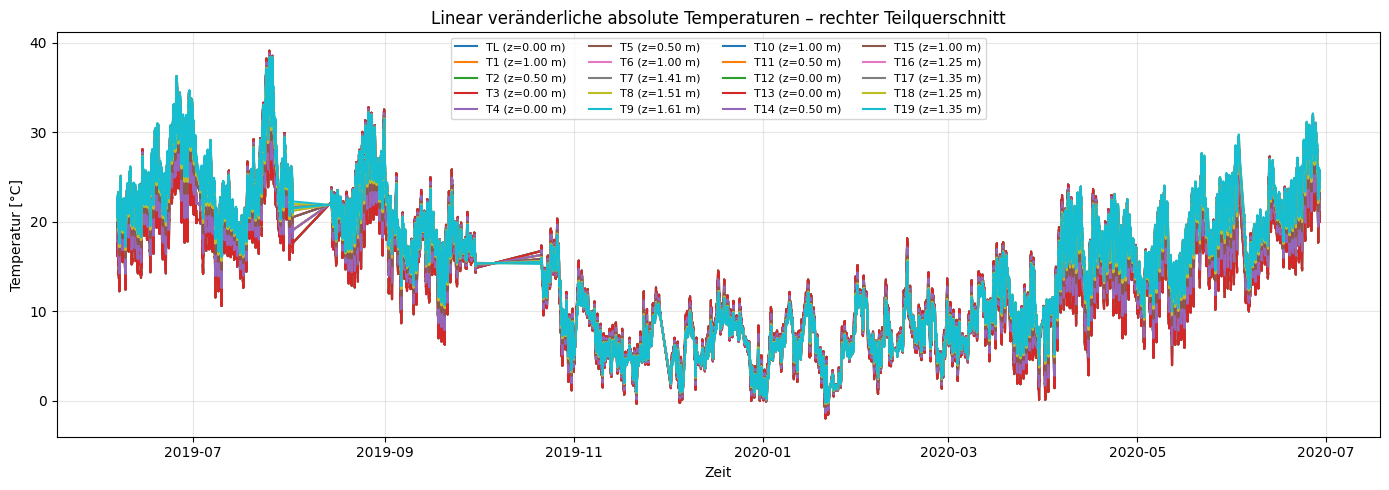

In [38]:
# =====================================================
# Linear veränderliche absolute Temperaturen – rechter Teilquerschnitt
# =====================================================

plt.figure(figsize=(14, 5))

a_rechts = gesamt_df["grad_rechter_steg"]

for z, sensor in zip(sensor_hoehen, sensoren_skizze):
    T_lin = TL + a_rechts * z
    plt.plot(gesamt_df.index, T_lin, label=f"{sensor} (z={z:.2f} m)")

plt.xlabel("Zeit")
plt.ylabel("Temperatur [°C]")
plt.title("Linear veränderliche absolute Temperaturen – rechter Teilquerschnitt")
plt.legend(ncol=4, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# minimale Sensoranordnung

# Vollständige Sensoranordnung (Referenz)
sensoren_voll = sensoren_skizze

# Variante A: nur obere Sensoren
sensoren_oben = ["TL", "T7", "T8", "T9", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"]

# Variante B: nur untere Sensoren
sensoren_unten = ["TL", "T1", "T2", "T3", "T4", "T5", "T6"]

# Variante C: minimale Anordnung (unten + oben)
sensoren_minimal = ["TL", "T1", "T3", "T6", "T9", "T12", "T15", "T18", "T19"]


gesamt_df["grad_voll"] = berechne_gradient_skizze(
    gesamt_df, sensoren_voll
)

gesamt_df["grad_oben"] = berechne_gradient_skizze(
    gesamt_df, sensoren_oben
)

gesamt_df["grad_unten"] = berechne_gradient_skizze(
    gesamt_df, sensoren_unten
)

gesamt_df["grad_minimal"] = berechne_gradient_skizze(
    gesamt_df, sensoren_minimal
)

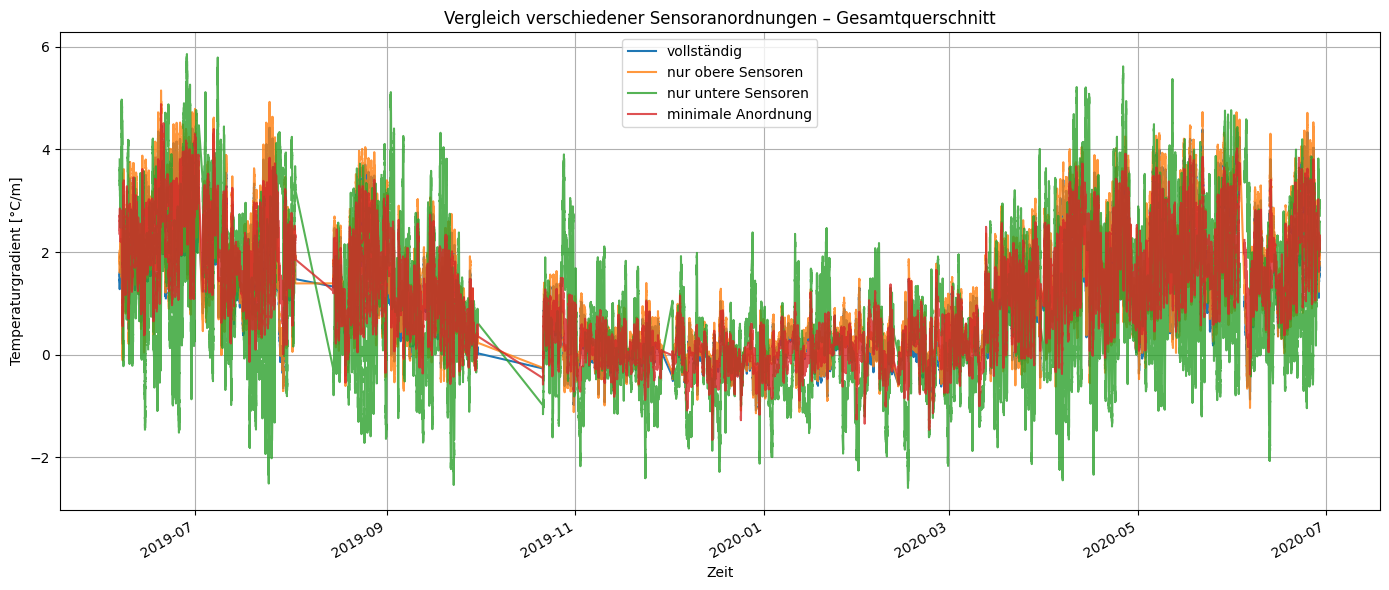

In [11]:
# Visualisierung
plt.figure(figsize=(14, 6))

gesamt_df["grad_voll"].plot(label="vollständig", linewidth=1.5)
gesamt_df["grad_oben"].plot(label="nur obere Sensoren", alpha=0.8)
gesamt_df["grad_unten"].plot(label="nur untere Sensoren", alpha=0.8)
gesamt_df["grad_minimal"].plot(label="minimale Anordnung", alpha=0.8)

plt.ylabel("Temperaturgradient [°C/m]")
plt.xlabel("Zeit")
plt.title("Vergleich verschiedener Sensoranordnungen – Gesamtquerschnitt")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
#Vergleich oberer und unterer Gradienten
vergleich = pd.DataFrame({
    "oben_vs_voll": gesamt_df["grad_oben"] - gesamt_df["grad_voll"],
    "unten_vs_voll": gesamt_df["grad_unten"] - gesamt_df["grad_voll"],
    "minimal_vs_voll": gesamt_df["grad_minimal"] - gesamt_df["grad_voll"],
})

vergleich.describe()

oben_vs_voll  unten_vs_voll  minimal_vs_voll
count  143914.000000  143914.000000    143914.000000
mean        0.115154      -0.345396         0.029384
std         0.153432       1.614382         0.404061
min        -0.426251      -5.728392        -1.261458
25%         0.032403      -1.335244        -0.238664
50%         0.122602      -0.243864         0.020267
75%         0.213121       0.725441         0.277263
max         0.686404       4.579709         1.495748

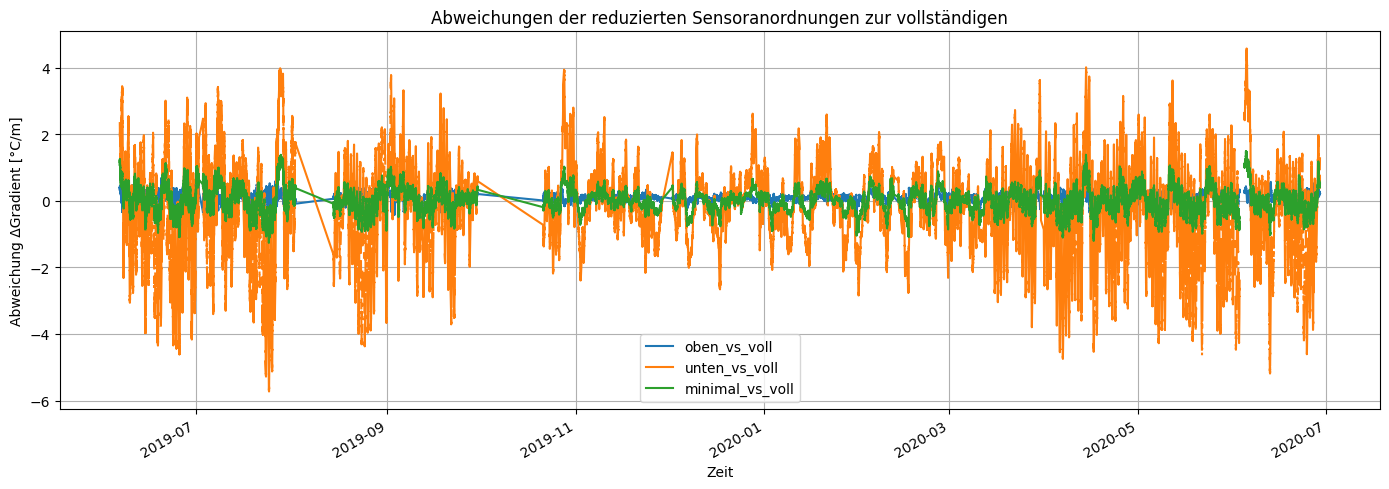

In [13]:
#Visualisierung der Abweichungen der Gradienten

plt.figure(figsize=(14, 5))

vergleich.plot(ax=plt.gca())

plt.ylabel("Abweichung ΔGradient [°C/m]")
plt.xlabel("Zeit")
plt.title("Abweichungen der reduzierten zur vollständigen Sensoranordnungen")
plt.grid(True)
plt.tight_layout()
plt.show()


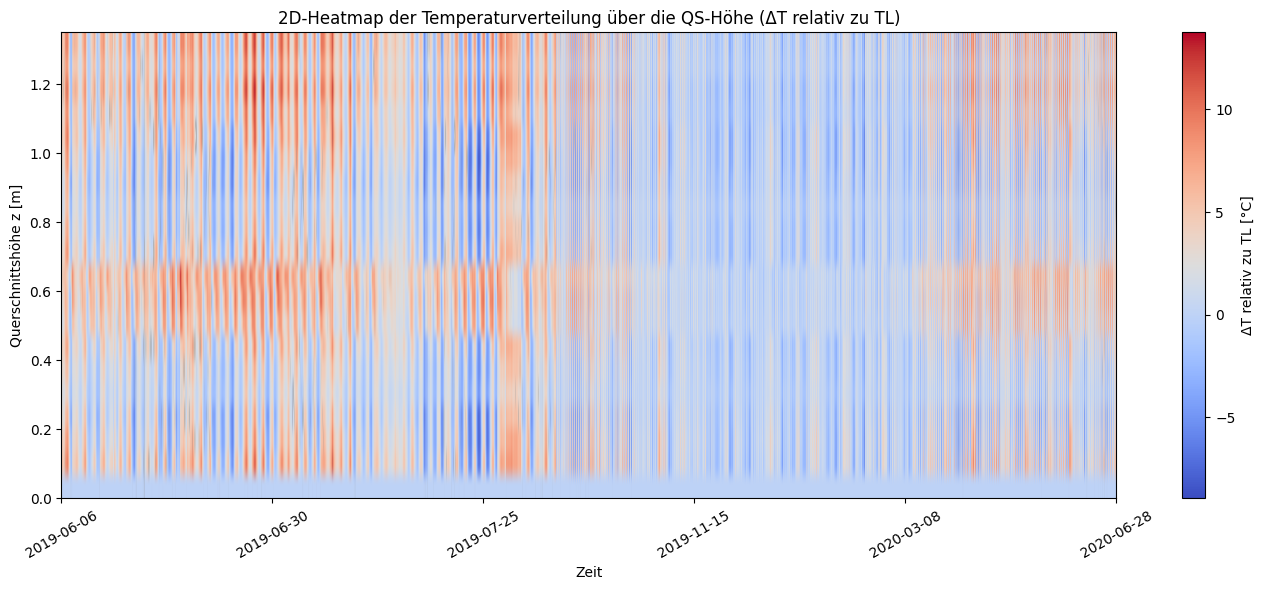

In [14]:
# =====================================================
# 2D-Heatmap: Temperaturverteilung über QS-Höhe und Zeit
# (ΔT relativ zu TL, Skizzenreihenfolge)
# =====================================================

import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------
# Zeitraum auswählen
# -----------------------------------------------------
start = "2019-06-06"
end   = "2020-06-28"

df_zeit = gesamt_df.loc[start:end]

# -----------------------------------------------------
# Sensordaten in Skizzenreihenfolge
# -----------------------------------------------------
werte = hole_sensorwerte(df_zeit, sensoren_skizze)

# Temperaturdifferenzen relativ zu TL
werte_rel = werte - werte[:, [0]]   # TL = erstes Element

# -----------------------------------------------------
# Heatmap plotten
# -----------------------------------------------------
plt.figure(figsize=(14, 6))

# imshow erwartet (y, x) -> daher Transponieren
im = plt.imshow(
    werte_rel.T,
    aspect="auto",
    origin="lower",
    extent=[
        0,
        len(df_zeit),
        sensor_hoehen[0],
        sensor_hoehen[-1]
    ],
    cmap="coolwarm"
)

# Farbskala
cbar = plt.colorbar(im)
cbar.set_label("ΔT relativ zu TL [°C]")

# Achsenbeschriftung
plt.ylabel("Querschnittshöhe z [m]")
plt.xlabel("Zeit")

# Zeitachse sinnvoll beschriften (ausgedünnt)
n_ticks = 6
tick_pos = np.linspace(0, len(df_zeit) - 1, n_ticks).astype(int)
tick_labels = df_zeit.index[tick_pos].strftime("%Y-%m-%d")

plt.xticks(tick_pos, tick_labels, rotation=30)

plt.title("2D-Heatmap der Temperaturverteilung über die QS-Höhe (ΔT relativ zu TL)")
plt.tight_layout()
plt.show()


In [15]:
# =====================================================
# Hilfsfunktion: 2D-Heatmap Höhe–Zeit
# =====================================================

def plot_heatmap(df, titel, cmap="coolwarm"):
    werte = hole_sensorwerte(df, sensoren_skizze)
    werte_rel = werte - werte[:, [0]]  # TL als Referenz

    plt.figure(figsize=(14, 5))

    im = plt.imshow(
        werte_rel.T,
        aspect="auto",
        origin="lower",
        extent=[
            0,
            len(df),
            sensor_hoehen[0],
            sensor_hoehen[-1]
        ],
        cmap=cmap
    )

    cbar = plt.colorbar(im)
    cbar.set_label("ΔT relativ zu TL [°C]")

    # Zeitachse sinnvoll beschriften
    n_ticks = 6
    tick_pos = np.linspace(0, len(df) - 1, n_ticks).astype(int)
    tick_labels = df.index[tick_pos].strftime("%Y-%m-%d %H:%M")

    plt.xticks(tick_pos, tick_labels, rotation=30)
    plt.ylabel("Querschnittshöhe z [m]")
    plt.xlabel("Zeit")
    plt.title(titel)
    plt.tight_layout()
    plt.show()


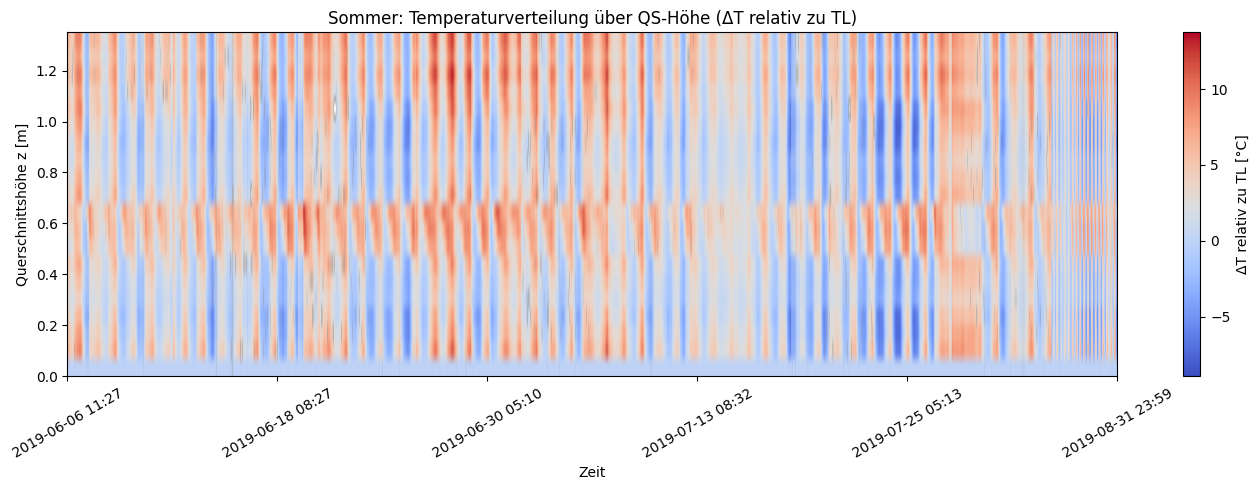

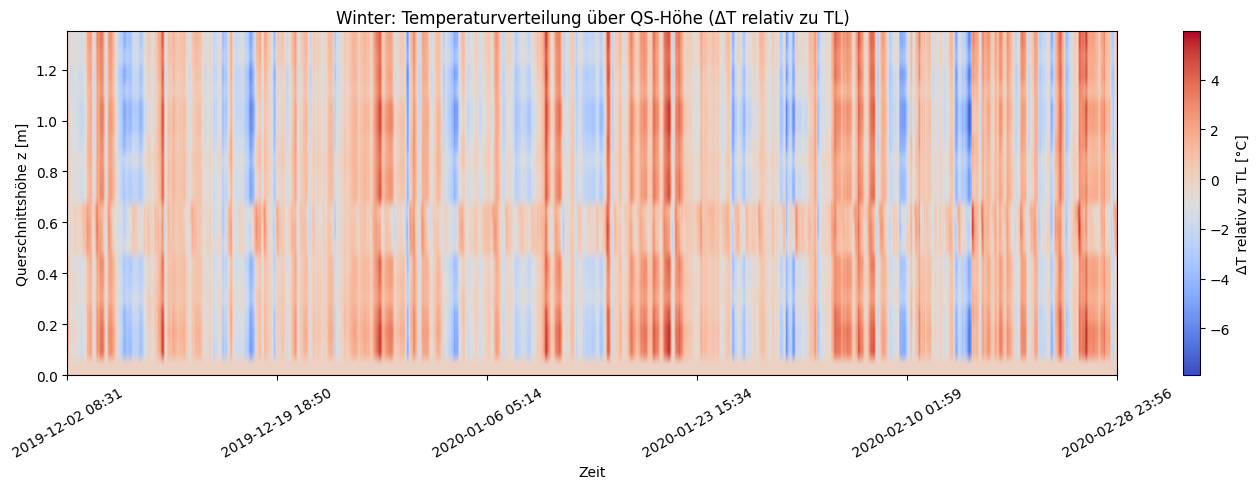

In [16]:
#Sommer HeatMap Juni-August
#Winter HeatMap Dezember-Februar

df_sommer = gesamt_df.loc["2019-06-01":"2019-08-31"]
df_winter = gesamt_df.loc["2019-12-01":"2020-02-28"]

plot_heatmap(df_sommer, "Sommer: Temperaturverteilung über QS-Höhe (ΔT relativ zu TL)")
plot_heatmap(df_winter, "Winter: Temperaturverteilung über QS-Höhe (ΔT relativ zu TL)")


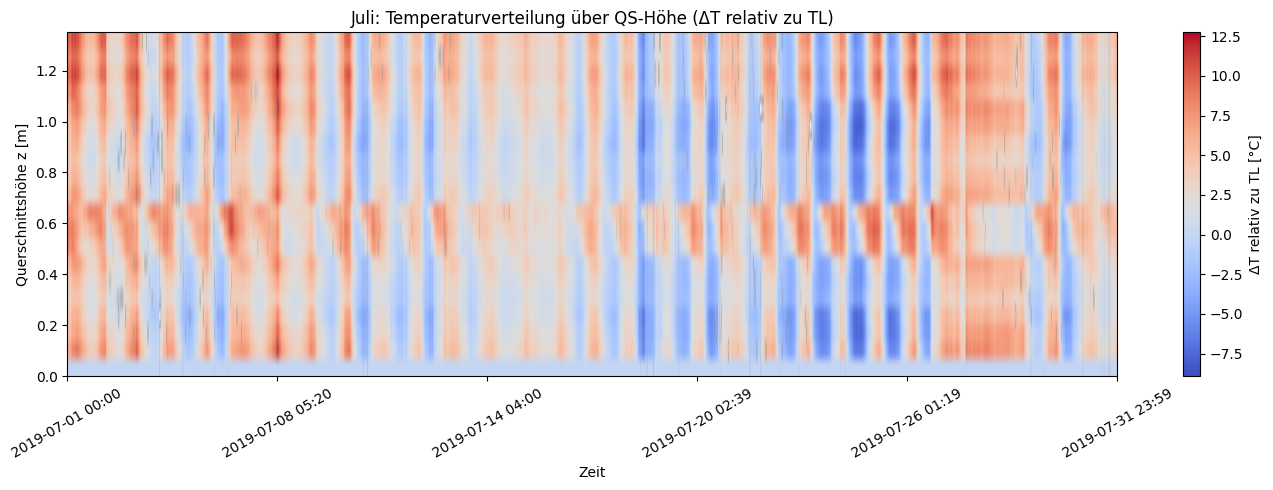

In [17]:
# =====================================================
# Ein Sommermonat (z. B. Juli)
# =====================================================

df_juli = gesamt_df.loc["2019-07-01":"2019-07-31"]

plot_heatmap(df_juli, "Juli: Temperaturverteilung über QS-Höhe (ΔT relativ zu TL)")


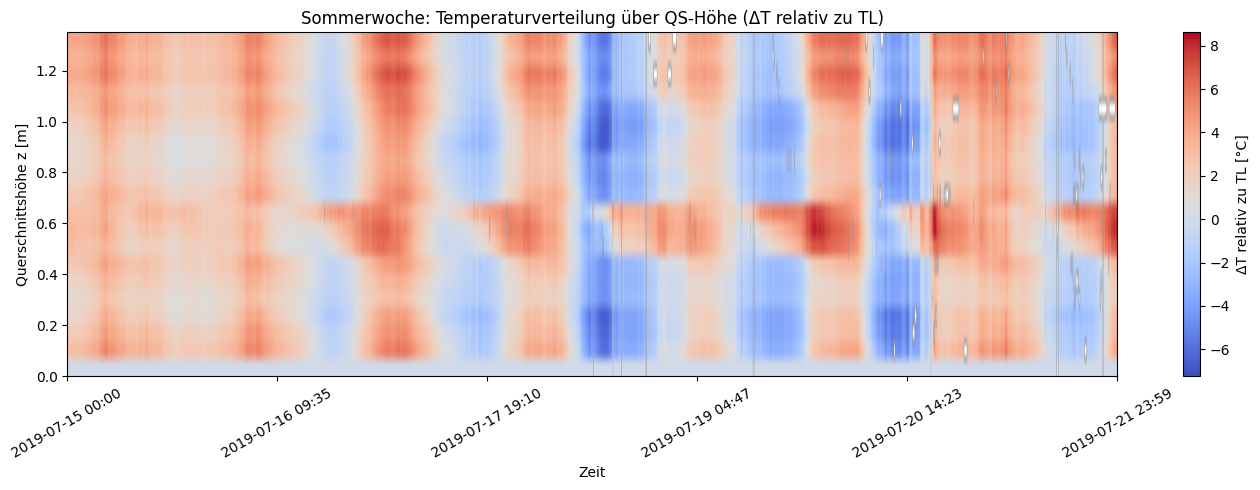

In [18]:
# =====================================================
# Eine Sommerwoche
# =====================================================

df_sommerwoche = gesamt_df.loc["2019-07-15":"2019-07-21"]

plot_heatmap(df_sommerwoche, "Sommerwoche: Temperaturverteilung über QS-Höhe (ΔT relativ zu TL)")


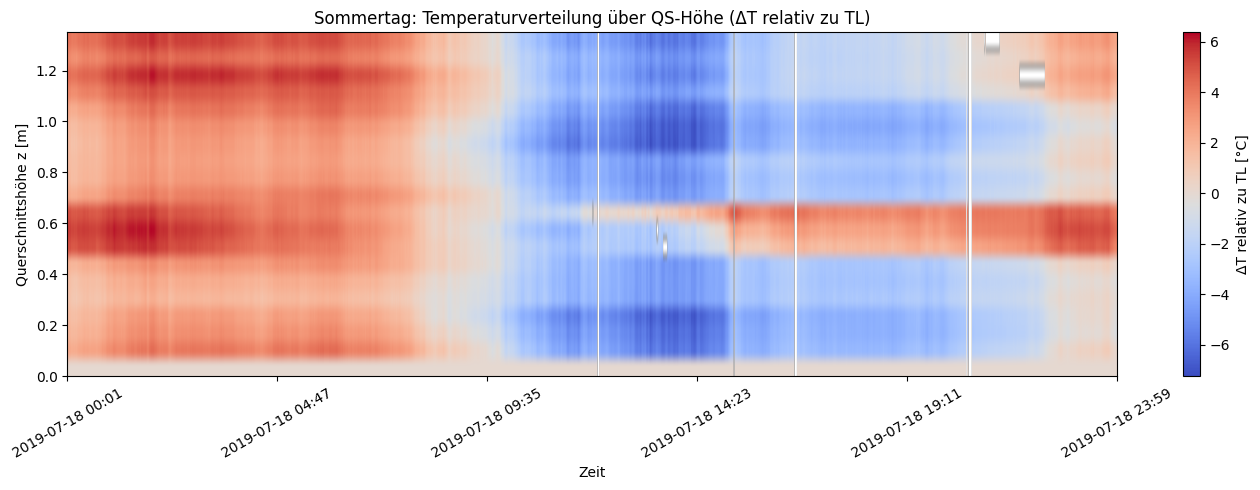

In [19]:
# =====================================================
# Ein Sommertag
# =====================================================

df_sommertag = gesamt_df.loc["2019-07-18"]

plot_heatmap(df_sommertag, "Sommertag: Temperaturverteilung über QS-Höhe (ΔT relativ zu TL)")


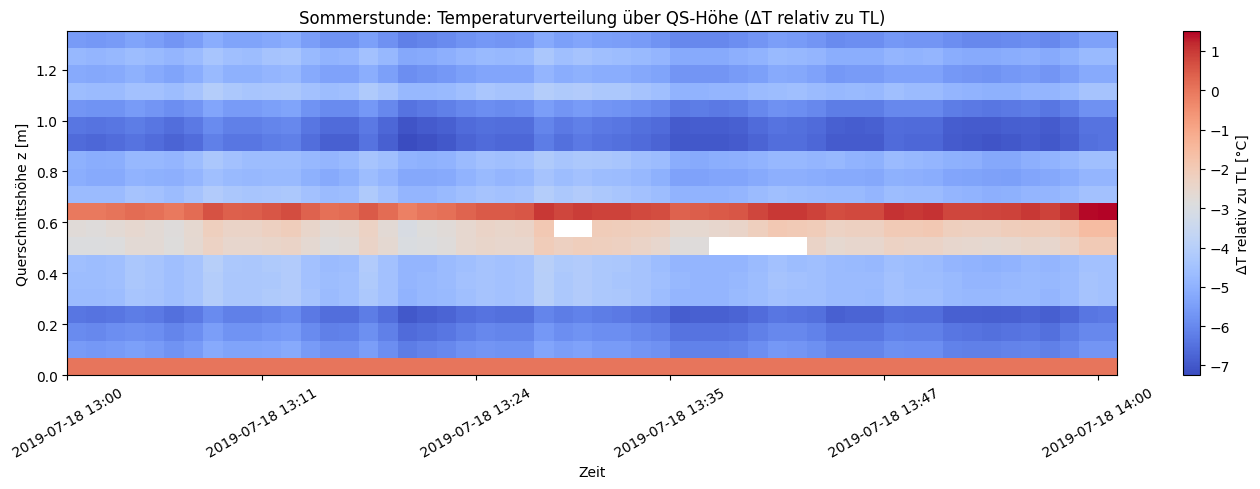

In [20]:
# =====================================================
# Eine Sommerstunde
# =====================================================

df_sommerstunde = gesamt_df.loc["2019-07-18 13:00":"2019-07-18 14:00"]

plot_heatmap(df_sommerstunde, "Sommerstunde: Temperaturverteilung über QS-Höhe (ΔT relativ zu TL)")


In [21]:
# Funktion: 2D-Heatmap absolute Temperaturen

def plot_heatmap_abs(df, titel, cmap="viridis"):
    werte = hole_sensorwerte(df, sensoren_skizze)

    plt.figure(figsize=(14, 5))

    im = plt.imshow(
        werte.T,
        aspect="auto",
        origin="lower",
        extent=[
            0,
            len(df),
            sensor_hoehen[0],
            sensor_hoehen[-1]
        ],
        cmap=cmap
    )

    cbar = plt.colorbar(im)
    cbar.set_label("Temperatur [°C]")

    # Zeitachse sinnvoll beschriften
    n_ticks = 6
    tick_pos = np.linspace(0, len(df) - 1, n_ticks).astype(int)
    tick_labels = df.index[tick_pos].strftime("%Y-%m-%d %H:%M")

    plt.xticks(tick_pos, tick_labels, rotation=30)
    plt.ylabel("Querschnittshöhe z [m]")
    plt.xlabel("Zeit")
    plt.title(titel)
    plt.tight_layout()
    plt.show()


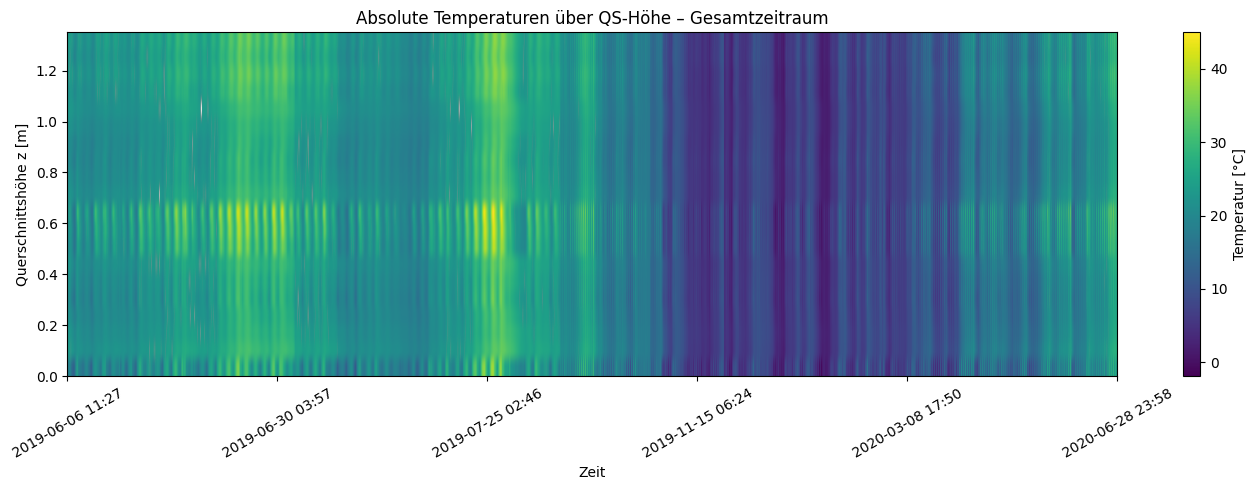

In [22]:
# =====================================================
# Absoluter Temperaturverlauf – Gesamtzeitraum
# =====================================================

plot_heatmap_abs(
    gesamt_df,
    "Absolute Temperaturen über QS-Höhe – Gesamtzeitraum"
)


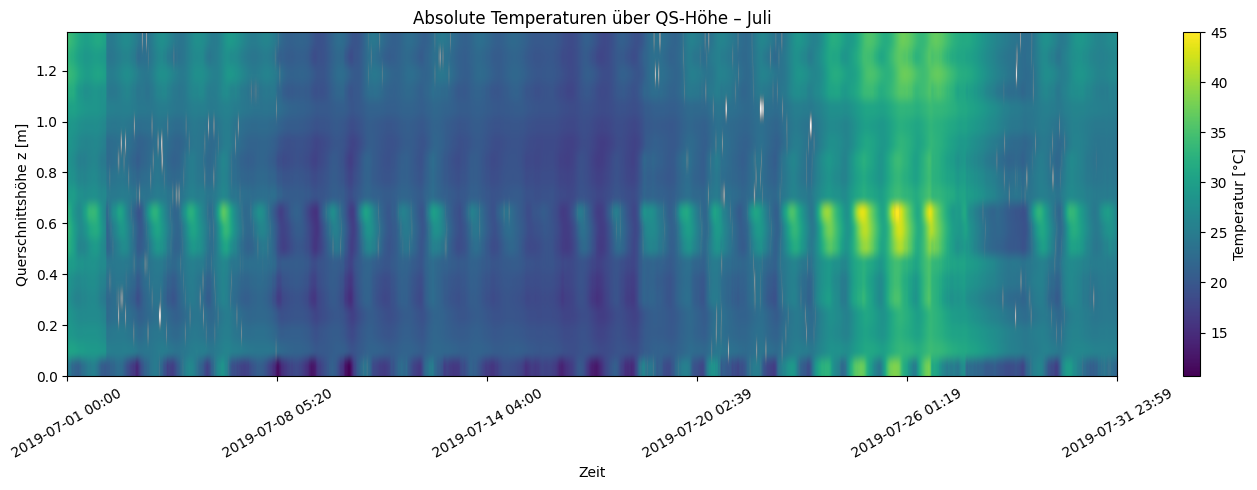

In [23]:
# =====================================================
# Absoluter Temperaturverlauf – Juli
# =====================================================

df_juli = gesamt_df.loc["2019-07-01":"2019-07-31"]

plot_heatmap_abs(
    df_juli,
    "Absolute Temperaturen über QS-Höhe – Juli"
)


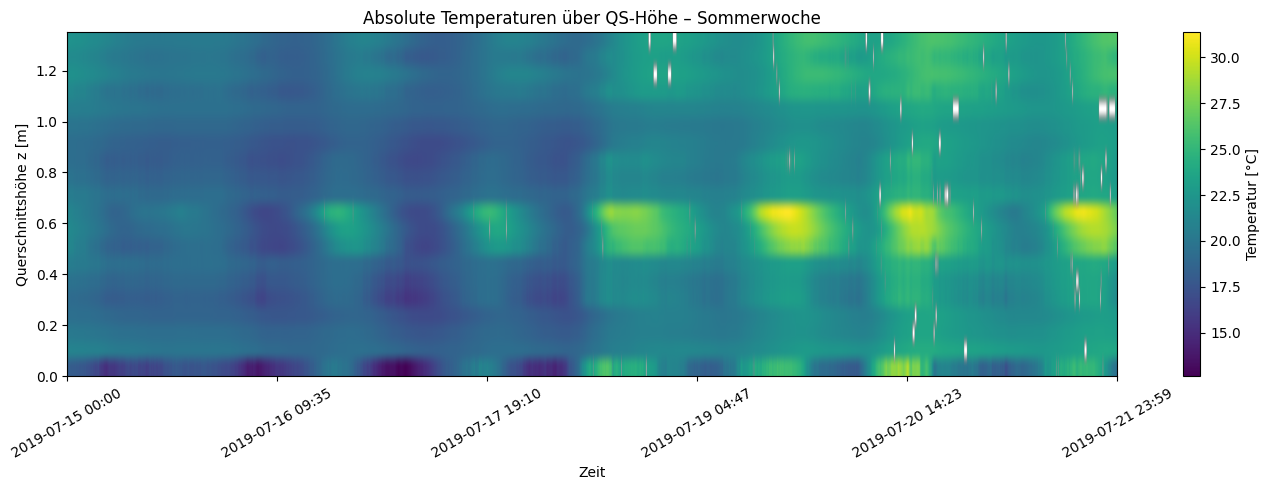

In [24]:
# =====================================================
# Absoluter Temperaturverlauf – Sommerwoche
# =====================================================

df_woche = gesamt_df.loc["2019-07-15":"2019-07-21"]

plot_heatmap_abs(
    df_woche,
    "Absolute Temperaturen über QS-Höhe – Sommerwoche"
)


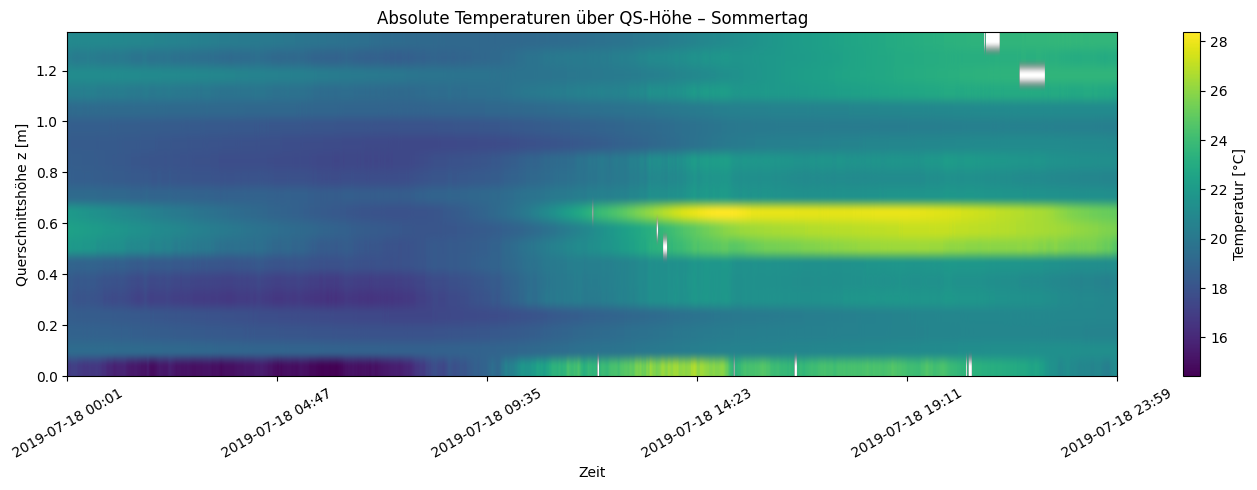

In [25]:
# =====================================================
# Absoluter Temperaturverlauf – Sommertag
# =====================================================

df_tag = gesamt_df.loc["2019-07-18"]

plot_heatmap_abs(
    df_tag,
    "Absolute Temperaturen über QS-Höhe – Sommertag"
)


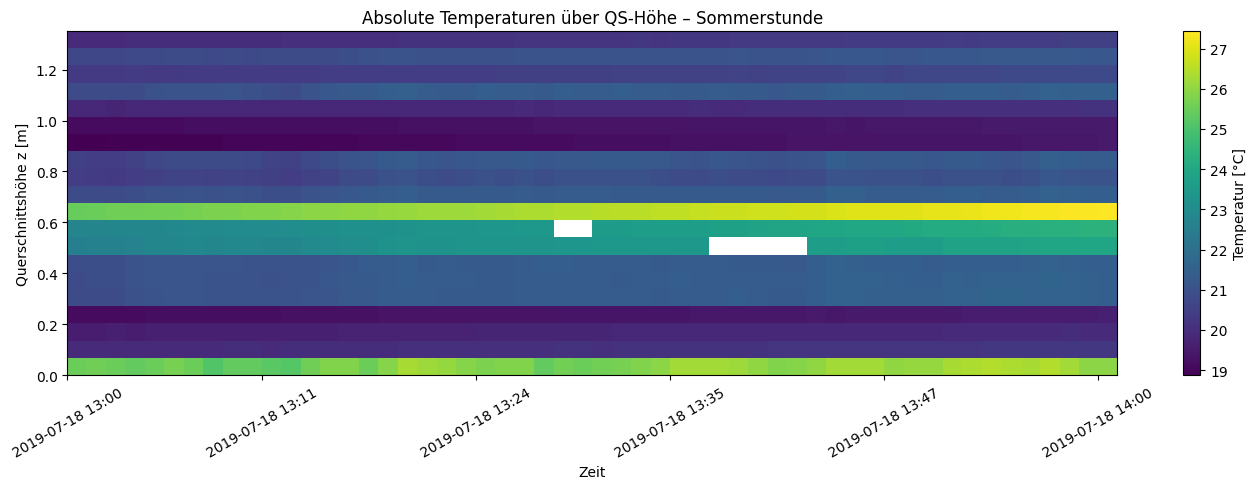

In [26]:
# =====================================================
# Absoluter Temperaturverlauf – Sommerstunde
# =====================================================

df_stunde = gesamt_df.loc["2019-07-18 13:00":"2019-07-18 14:00"]

plot_heatmap_abs(
    df_stunde,
    "Absolute Temperaturen über QS-Höhe – Sommerstunde"
)


In [33]:
# =====================================================
# Gestapelte Zeitreihen: absolute Temperaturen nach QS-Höhe
# =====================================================

def plot_gestapelte_zeitreihen(df, titel, skalierung=5):
    """
    skalierung: bestimmt, wie stark die Höhenabstände wirken
    """
    werte = hole_sensorwerte(df, sensoren_skizze)

    plt.figure(figsize=(14, 6))

    for i, sensor in enumerate(sensoren_skizze):
        offset = sensor_hoehen[i] * skalierung
        plt.plot(
            df.index,
            werte[:, i] + offset,
            label=sensor
        )

    plt.xlabel("Zeit")
    plt.ylabel("Temperatur + Höhenoffset")
    plt.title(titel)
    plt.grid(True, alpha=0.3)

    # Legende bewusst klein halten
    plt.legend(
        ncol=4,
        fontsize=8,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15)
    )

    plt.tight_layout()
    plt.show()


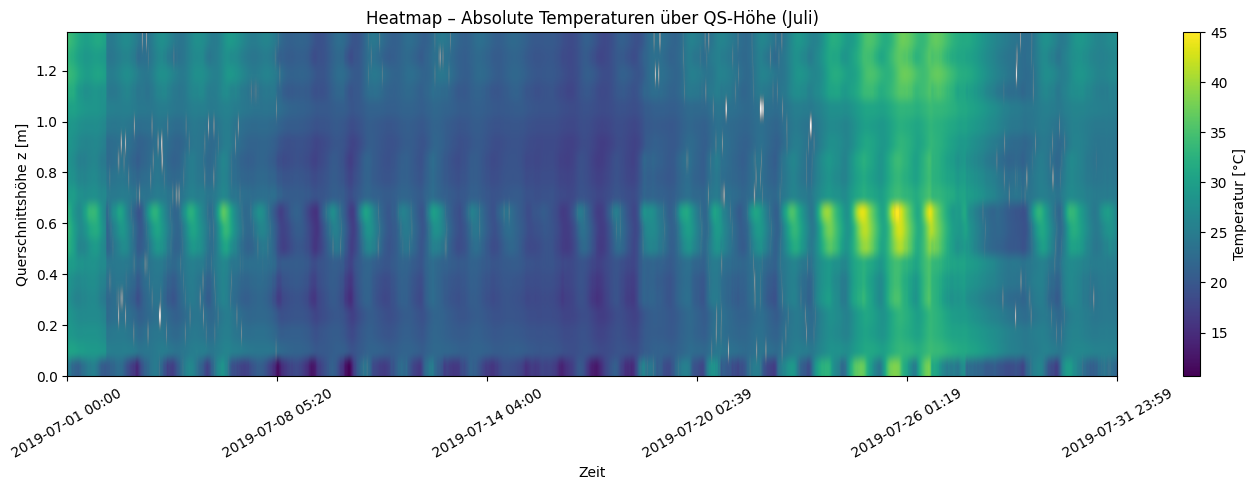

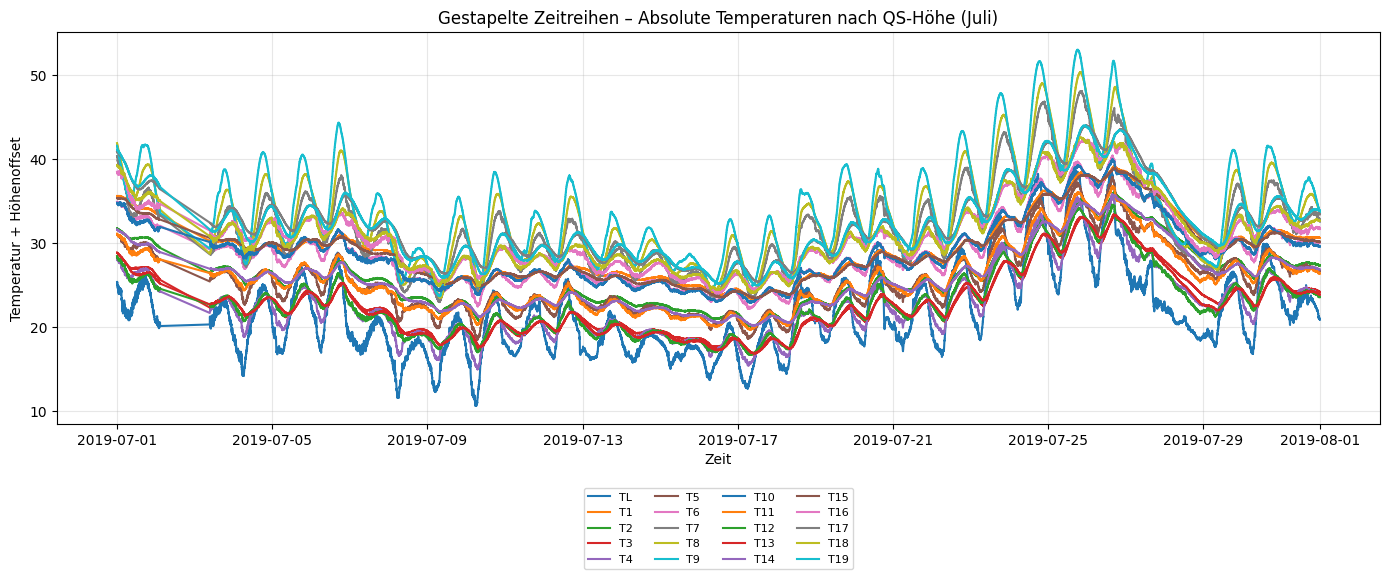

In [34]:
# =====================================================
# Kombination: Heatmap + gestapelte Zeitreihen (Juli)
# =====================================================

df_juli = gesamt_df.loc["2019-07-01":"2019-07-31"]

# Heatmap (Überblick)
plot_heatmap_abs(
    df_juli,
    "Heatmap – Absolute Temperaturen über QS-Höhe (Juli)"
)

# Gestapelte Zeitreihen (Detail)
plot_gestapelte_zeitreihen(
    df_juli,
    "Gestapelte Zeitreihen – Absolute Temperaturen nach QS-Höhe (Juli)"
)


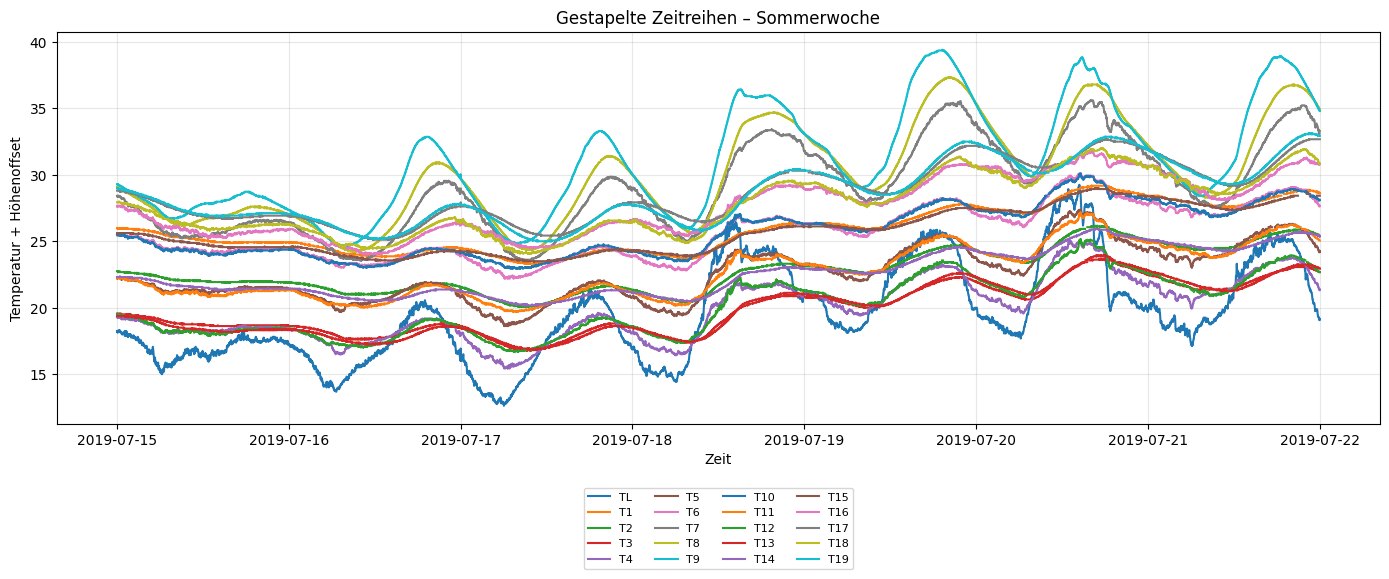

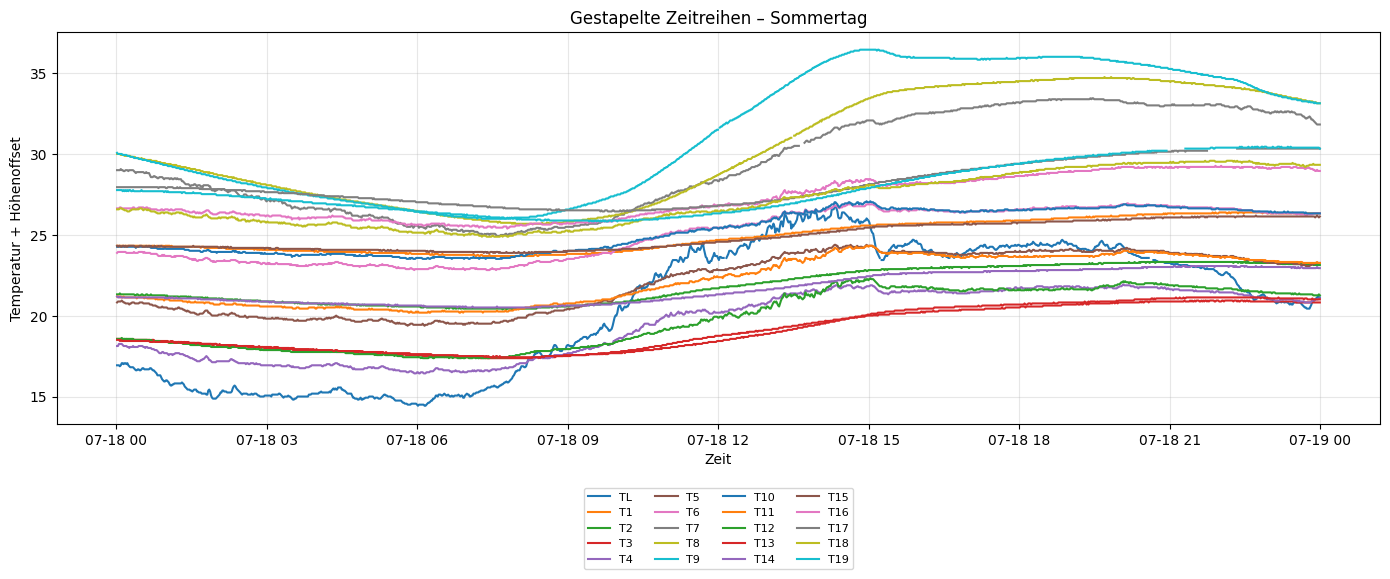

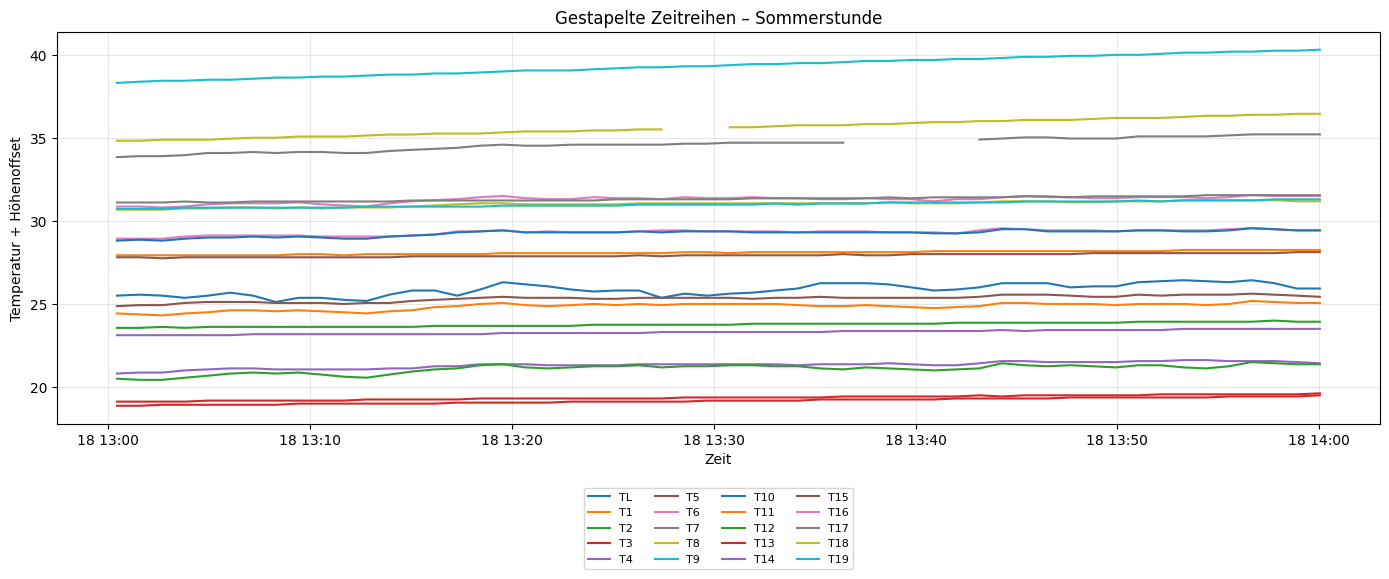

In [35]:
# =====================================================
# Weitere Zeitfenster
# =====================================================

df_woche  = gesamt_df.loc["2019-07-15":"2019-07-21"]
df_tag    = gesamt_df.loc["2019-07-18"]
df_stunde = gesamt_df.loc["2019-07-18 13:00":"2019-07-18 14:00"]

plot_gestapelte_zeitreihen(
    df_woche,
    "Gestapelte Zeitreihen – Sommerwoche"
)

plot_gestapelte_zeitreihen(
    df_tag,
    "Gestapelte Zeitreihen – Sommertag"
)

plot_gestapelte_zeitreihen(
    df_stunde,
    "Gestapelte Zeitreihen – Sommerstunde",
    skalierung=8   # etwas größerer Abstand bei kurzer Zeit
)


In [27]:
#AUFGABE 2 - Extremwerte

grad = gesamt_df["temp_gradient"].dropna()


In [28]:
# =====================================================
# 3-Tages-Extremwerte
# =====================================================

window = "3D"

grad_3d_max = grad.resample(window).max()
grad_3d_min = grad.resample(window).min()


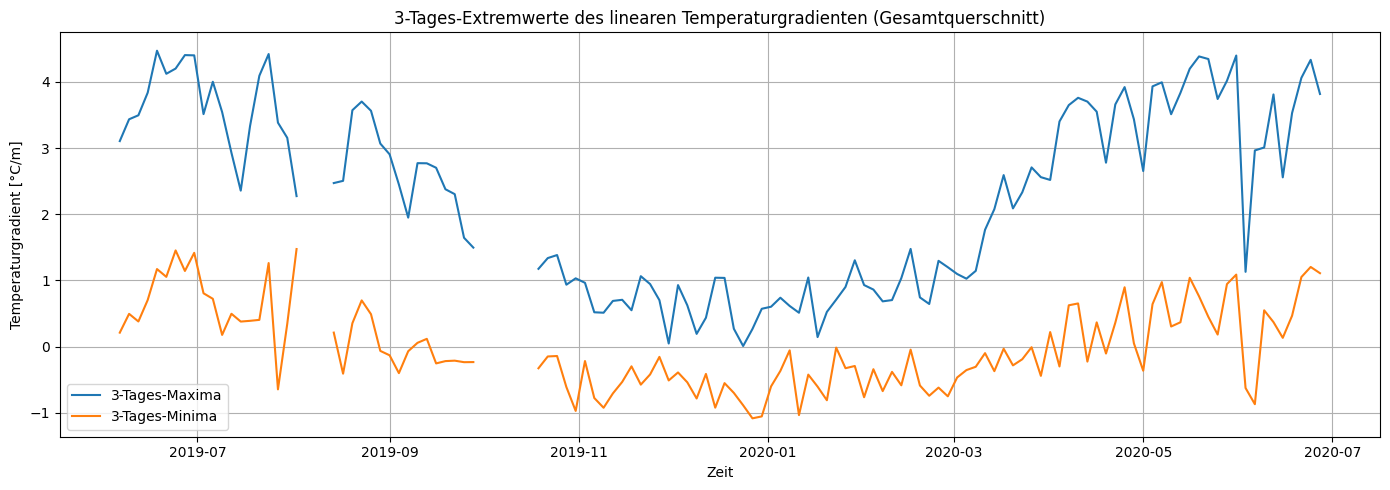

In [29]:
# =====================================================
# Visualisierung der 3-Tages-Extremwerte
# =====================================================

plt.figure(figsize=(14, 5))
plt.plot(grad_3d_max.index, grad_3d_max, label="3-Tages-Maxima")
plt.plot(grad_3d_min.index, grad_3d_min, label="3-Tages-Minima")
plt.ylabel("Temperaturgradient [°C/m]")
plt.xlabel("Zeit")
plt.title("3-Tages-Extremwerte des linearen Temperaturgradienten (Gesamtquerschnitt)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# =====================================================
# Weibull-Fit der 3-Tages-Maxima
# =====================================================

from scipy.stats import weibull_min

data = grad_3d_max.dropna().values

shape, loc, scale = weibull_min.fit(data, floc=0)

shape, scale


(np.float64(1.5630108758347192), np.float64(2.511831704838314))

In [31]:
# =====================================================
# Charakteristischer Wert & Bemessungswert
# =====================================================

p_k = 0.98
p_d = 0.999

T_k = weibull_min.ppf(p_k, shape, loc=0, scale=scale)
T_d = weibull_min.ppf(p_d, shape, loc=0, scale=scale)

gamma_T = T_d / T_k

T_k, T_d, gamma_T


(np.float64(6.011785985225739),
 np.float64(8.649492050170181),
 np.float64(1.4387558158967626))

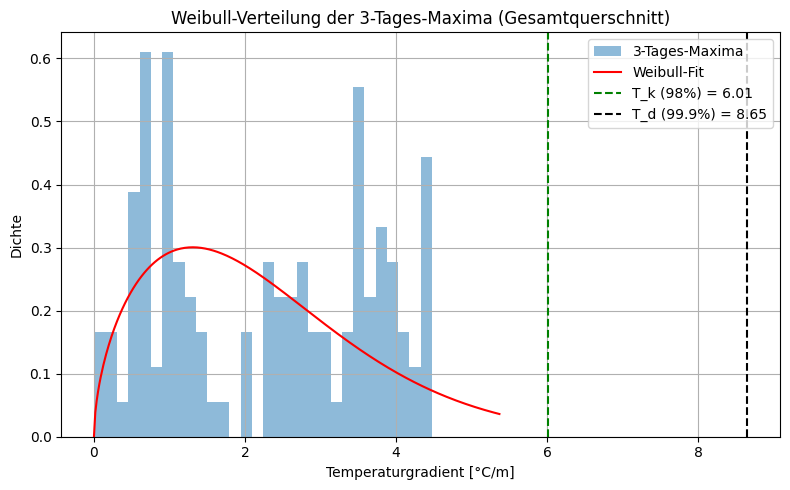

In [32]:
# =====================================================
# Visualisierung: Weibull-Verteilung
# =====================================================

x = np.linspace(0, data.max() * 1.2, 300)
pdf = weibull_min.pdf(x, shape, loc=0, scale=scale)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, density=True, alpha=0.5, label="3-Tages-Maxima")
plt.plot(x, pdf, "r", label="Weibull-Fit")

plt.axvline(T_k, color="green", linestyle="--", label=f"T_k (98%) = {T_k:.2f}")
plt.axvline(T_d, color="black", linestyle="--", label=f"T_d (99.9%) = {T_d:.2f}")

plt.xlabel("Temperaturgradient [°C/m]")
plt.ylabel("Dichte")
plt.title("Weibull-Verteilung der 3-Tages-Maxima (Gesamtquerschnitt)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
